# Train Xception for Plantas50
Finetuning the Xception model trained in the ImageNet dataset for Plantas50.

The training will occur in two stages. The first we will freeze all Xception weights and train only the layers in the classification part. The second we will train with all weights.

In [1]:
import tensorflow as tf
import numpy as np
import os.path

from tensorflow import keras
from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt

### Download the Plantas50
- Download the Plantas50 dataset by using our [Downloader](https://github.com/reneoctavio/plantas/raw/master/download_plantas50.py)
- Prepare your TFRecords using our [script](https://github.com/reneoctavio/plantas/raw/master/prepare_tfrecord_plantas50.py)

Then execute them:

- `python download_plantas50.py /path/to/dir`
- `python prepare_tfrecord_plantas50.py /path/to/Plantas50`

In [2]:
# Files for the TFRecords and labels file
train_file  = os.path.expanduser('~/Projects/Datasets/Plantas50/Plantas50_train.tfrecord')
valid_file  = os.path.expanduser('~/Projects/Datasets/Plantas50/Plantas50_valid.tfrecord')
test_file   = os.path.expanduser('~/Projects/Datasets/Plantas50/Plantas50_test.tfrecord')
labels_file = os.path.expanduser('~/Projects/Datasets/Plantas50/labels-ids.txt')

In [3]:
# Dictionary that will map labels to ids
labels_to_ids = {}
ids_to_labels = {}
with open(labels_file, 'r') as f:
    for l in f.readlines():
        name, idx = l.strip().split(',')
        labels_to_ids[name] = int(idx)
        ids_to_labels[int(idx)] = name

In [4]:
# Set some project constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
EPOCHS_STAGE_ONE = 10
EPOCHS_STAGE_TWO = 100
IMAGE_SIZE = 224
NUM_LABELS = 50
NUM_PARALLEL_CALLS = 4
NUM_TRAINING_IMAGES = 26669
NUM_VALIDATION_IMAGES = 3333
NUM_TEST_IMAGES = 3335
SHUFFLE_BUFFER = 1000
STEPS_PER_EPOCH = int(np.ceil(NUM_TRAINING_IMAGES / BATCH_SIZE))

## Preprocessing images
For evaluation we take a central crop and resize.

For training we take a random crop, resize, randomly flip and randomly distort.
Images must be in range -1 to 1.

The images were saved as JPEG, thus we have to decode it before preprocessing.

We also create a one-hot vector of the label.

In [5]:
def _preprocess_image(image, size, is_training=False):
    # Range [0, 1]
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    # Evaluation
    if not is_training:
        image = tf.image.central_crop(image, central_fraction=0.875)
        image = tf.image.resize_images(image, size)
    else:
        # Get random part of image
        bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
        bbegin, bsize, bbox = tf.image.sample_distorted_bounding_box(tf.shape(image), 
                                                                     bbox, 
                                                                     min_object_covered=0.75,
                                                                     aspect_ratio_range=[0.75, 1.33],
                                                                     area_range=[0.75, 1.],
                                                                     max_attempts=100,
                                                                     use_image_if_no_bounding_boxes=True)
        image = tf.slice(image, bbegin, bsize)
        image.set_shape([None, None, 3])
        image = tf.image.resize_images(image, size)

        # Random flip
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)

        # Random distort
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    
    # Range [-1, 1]
    image = tf.multiply(image, 2.0)
    image = tf.subtract(image, 1.0)
    
    # Make sure is within range
    image = tf.clip_by_value(image, -1.0, 1.0)
    
    return image

    
def _parse_function(example, img_size, num_labels, is_training=False):
    # Description of the data
    feature_description = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/class/label': tf.FixedLenFeature([], tf.int64, default_value=tf.zeros([], dtype=tf.int64))
    }
       
    # Extract example
    example = tf.parse_single_example(example, feature_description)
    image = tf.cast(tf.image.decode_jpeg(example['image/encoded'], channels=3), dtype=tf.uint8)
    label = example['image/class/label']
    
    # Preprocess image
    image = _preprocess_image(image, img_size, is_training=is_training)
    label = tf.one_hot(label, num_labels)
    
    return image, label

In [6]:
# Create a dataset object ready for use
def create_dataset(filepath, batch_size, img_size, num_labels, is_training=False):
    
    _map = lambda example: _parse_function(example, img_size, num_labels, is_training=is_training)
    dataset = tf.data.TFRecordDataset(filepath)
    dataset = dataset.map(_map, num_parallel_calls=NUM_PARALLEL_CALLS)
    dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER).repeat()
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [7]:
# Create dataset objects for training and validation
train_dataset = create_dataset(train_file, BATCH_SIZE, [IMAGE_SIZE, IMAGE_SIZE], NUM_LABELS, is_training=True)
valid_dataset = create_dataset(valid_file, BATCH_SIZE, [IMAGE_SIZE, IMAGE_SIZE], NUM_LABELS, is_training=False)

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## Model
We will read the Xception model with ImageNet weights and then create a classification module in order to finetune our model for Plantas50.

First we will not train the weights of the Xception model. 

The output of the last Dense layer have the size of the number of species.

In [8]:
# Load Base model with pre-trained weights
base_model = Xception(weights='imagenet', 
                         include_top=False, 
                         input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all Base model layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Create the classification module
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.Dense(NUM_LABELS, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=x)

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]       

In [10]:
# Batch by batch logger
class Logger(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
        self.topkacc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
        self.topkacc.append(logs.get('top_k_categorical_accuracy'))

In [11]:
# SGD Scheduler (Decrease from 0.1 to 0.001 per epoch)
def schedule(epoch, lr):
    if epoch < 1:
        return lr
    return lr * 10**(-2./(EPOCHS_STAGE_ONE - 1.))
    
# Callback to save model
simple_logger = Logger()
callbacks = [keras.callbacks.ModelCheckpoint('xception_plantas50_simple_weights.{epoch:02d}-{val_acc:.2f}.hdf5', 
                                             save_best_only=True),
             keras.callbacks.LearningRateScheduler(schedule, verbose=1),
             keras.callbacks.CSVLogger('xception_plantas50_simple_log.csv'),
             simple_logger
            ]

# Set loss, optimizer and metrics
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=8e-5, nesterov=True),
              metrics=['acc', keras.metrics.top_k_categorical_accuracy])

# Train the model
simple = model.fit(train_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    epochs = EPOCHS_STAGE_ONE,
                    callbacks=callbacks,
                    validation_data = valid_dataset,
                    validation_steps = int(np.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE)),
                    verbose = 1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/10
1667/1667 [==============================] - 153s 92ms/step - loss: 2.8392 - acc: 0.2836 - top_k_categorical_accuracy: 0.5643 - val_loss: 4.3057 - val_acc: 0.2742 - val_top_k_categorical_accuracy: 0.5571

Epoch 00002: LearningRateScheduler reducing learning rate to 0.059948425925195246.
Epoch 2/10
1667/1667 [==============================] - 148s 89ms/step - loss: 2.1470 - acc: 0.4500 - top_k_categorical_accuracy: 0.7320 - val_loss: 3.6001 - val_acc: 0.3322 - val_top_k_categorical_accuracy: 0.6618

Epoch 00003: LearningRateScheduler reducing learning rate to 0.035938137062546754.
Epoch 3/10
1667/1667 [==============================] - 149s 89ms/step - loss: 1.6800 - acc: 0.5508 - top_k_categorical_accuracy: 0.8219 - val_loss: 2.5531 - val_acc: 0.4435 - val_top_k_categorical_accuracy: 0.7479

Epoch 00004: LearningRateScheduler reducing learning rate to 0.02154434668542574.
Epoch 4/10
1667/1667 

### Stage one results
Validation accuracy of 49.58%, and top-5 of 79.01%

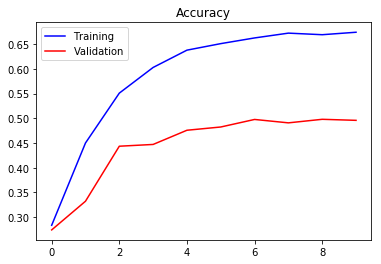

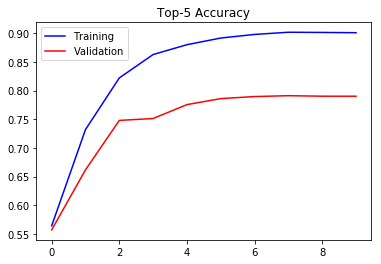

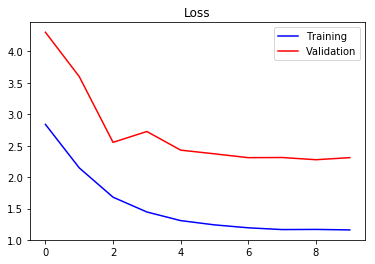

In [12]:
acc = simple.history['acc']
val_acc = simple.history['val_acc']
loss = simple.history['loss']
val_loss = simple.history['val_loss']
top5_acc = simple.history['top_k_categorical_accuracy']
val_top5_acc = simple.history['val_top_k_categorical_accuracy']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, top5_acc, 'b', label='Training')
plt.plot(epochs, val_top5_acc, 'r', label='Validation')
plt.title('Top-5 Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

## Stage two training
We will now train the whole network.

In [13]:
# SGD Scheduler (Decrease from 0.01 to 0.0001 per epoch)
def schedule(epoch, lr):
    if epoch < 1:
        return lr
    return lr * 10**(-2./(EPOCHS_STAGE_TWO - 1.))

# Unfreeze all model layers
for layer in model.layers:
    layer.trainable = True
    
# Callback to save model
complete_logger = Logger()
callbacks = [keras.callbacks.ModelCheckpoint('xception_plantas50_complete_weights.{epoch:02d}-{val_acc:.2f}.hdf5', 
                                             save_best_only=True),
             keras.callbacks.LearningRateScheduler(schedule, verbose=1),
             keras.callbacks.CSVLogger('xception_plantas50_complete_log.csv'),
             complete_logger
            ]
    
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=8e-5, nesterov=True),
              metrics=['acc', keras.metrics.top_k_categorical_accuracy])

complete = model.fit(train_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    epochs = EPOCHS_STAGE_TWO,
                    callbacks=callbacks,
                    validation_data = valid_dataset,
                    validation_steps = int(np.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE)),
                    verbose = 1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/100
1667/1667 [==============================] - 703s 422ms/step - loss: 1.0148 - acc: 0.7111 - top_k_categorical_accuracy: 0.9263 - val_loss: 0.5627 - val_acc: 0.8436 - val_top_k_categorical_accuracy: 0.9671

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009545484353260135.
Epoch 2/100
1667/1667 [==============================] - 695s 417ms/step - loss: 0.5100 - acc: 0.8537 - top_k_categorical_accuracy: 0.9735 - val_loss: 0.3758 - val_acc: 0.8980 - val_top_k_categorical_accuracy: 0.9809

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009111627552687572.
Epoch 3/100
1667/1667 [==============================] - 694s 417ms/step - loss: 0.3515 - acc: 0.8974 - top_k_categorical_accuracy: 0.9858 - val_loss: 0.2915 - val_acc: 0.9112 - val_top_k_categorical_accuracy: 0.9889

Epoch 00004: LearningRateScheduler reducing learning rate to 0.008697490384332363.
Epoch 4/100
1

1667/1667 [==============================] - 687s 412ms/step - loss: 0.0158 - acc: 0.9949 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.1441 - val_acc: 0.9683 - val_top_k_categorical_accuracy: 0.9964

Epoch 00029: LearningRateScheduler reducing learning rate to 0.002718588262120373.
Epoch 29/100
1667/1667 [==============================] - 686s 411ms/step - loss: 0.0150 - acc: 0.9955 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.1405 - val_acc: 0.9695 - val_top_k_categorical_accuracy: 0.9967

Epoch 00030: LearningRateScheduler reducing learning rate to 0.002595024301670684.
Epoch 30/100
1667/1667 [==============================] - 687s 412ms/step - loss: 0.0148 - acc: 0.9955 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1455 - val_acc: 0.9701 - val_top_k_categorical_accuracy: 0.9958

Epoch 00031: LearningRateScheduler reducing learning rate to 0.0024770765515056024.
Epoch 31/100
1667/1667 [==============================] - 686s 412ms/step - loss: 0.0151 - acc: 0.9955 - t

1667/1667 [==============================] - 690s 414ms/step - loss: 0.0129 - acc: 0.9960 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1444 - val_acc: 0.9698 - val_top_k_categorical_accuracy: 0.9961

Epoch 00056: LearningRateScheduler reducing learning rate to 0.0007742637069019472.
Epoch 56/100
1667/1667 [==============================] - 690s 414ms/step - loss: 0.0112 - acc: 0.9967 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1381 - val_acc: 0.9725 - val_top_k_categorical_accuracy: 0.9958

Epoch 00057: LearningRateScheduler reducing learning rate to 0.0007390722154437736.
Epoch 57/100
1667/1667 [==============================] - 692s 415ms/step - loss: 0.0103 - acc: 0.9970 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1366 - val_acc: 0.9710 - val_top_k_categorical_accuracy: 0.9961

Epoch 00058: LearningRateScheduler reducing learning rate to 0.0007054802437884616.
Epoch 58/100
1667/1667 [==============================] - 692s 415ms/step - loss: 0.0117 - acc: 0.9966 -

1667/1667 [==============================] - 710s 426ms/step - loss: 0.0114 - acc: 0.9966 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1418 - val_acc: 0.9722 - val_top_k_categorical_accuracy: 0.9967

Epoch 00083: LearningRateScheduler reducing learning rate to 0.0002205131098528085.
Epoch 83/100
1667/1667 [==============================] - 711s 427ms/step - loss: 0.0117 - acc: 0.9958 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1280 - val_acc: 0.9737 - val_top_k_categorical_accuracy: 0.9955

Epoch 00084: LearningRateScheduler reducing learning rate to 0.00021049045531623572.
Epoch 84/100
1667/1667 [==============================] - 708s 425ms/step - loss: 0.0106 - acc: 0.9969 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1382 - val_acc: 0.9707 - val_top_k_categorical_accuracy: 0.9961

Epoch 00085: LearningRateScheduler reducing learning rate to 0.0002009233399968268.
Epoch 85/100
1667/1667 [==============================] - 710s 426ms/step - loss: 0.0123 - acc: 0.9963 

## Training analysis

Finetuning seems to be working and with little overfitting.

The next time, we can reduce the number of epochs. It converged to the same validation accuracy in epoch around 20.

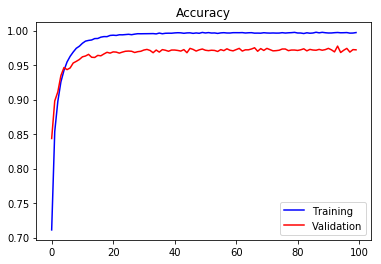

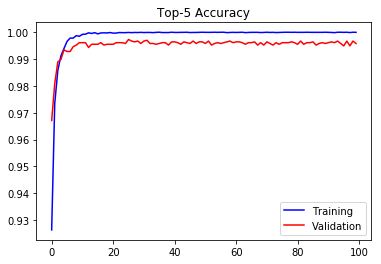

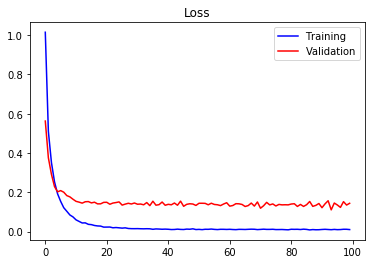

In [14]:
acc = complete.history['acc']
val_acc = complete.history['val_acc']
loss = complete.history['loss']
val_loss = complete.history['val_loss']
top5_acc = complete.history['top_k_categorical_accuracy']
val_top5_acc = complete.history['val_top_k_categorical_accuracy']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, top5_acc, 'b', label='Training')
plt.plot(epochs, val_top5_acc, 'r', label='Validation')
plt.title('Top-5 Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

## Evaluation
Let's see how our model will do with out test set.

First we will verify the accuracy and top-5 accuracy of the test set, then we will take some image examples from the test set and predict their species.

The test set accuracy is 97.19% and top-5 accuracy is 99.73%. 

In our paper, the best model (GoogLeNet or Inception v1) gave 94.6% accuracy and 99.2% top-5 accuracy. Here, Xception gave even better results. However, we increased the size of the training set to 80%, leaving 10% for both validation and test set, instead of the 70%, 15%, 15% used in the paper.

This is just an example, and is not supposed to be compared directly with the method used in the paper.

In [15]:
# Evaluation
test_dataset = create_dataset(test_file, BATCH_SIZE, [IMAGE_SIZE, IMAGE_SIZE], NUM_LABELS, is_training=False)

out = model.evaluate(test_dataset, 
                     batch_size=BATCH_SIZE, 
                     verbose=1, 
                     steps=int(np.ceil(NUM_TEST_IMAGES / BATCH_SIZE)))

209/209 [==============================] - 17s 81ms/step - loss: 0.1123 - acc: 0.9719 - top_k_categorical_accuracy: 0.9973


In [16]:
# Predict for a batch of test images
test_iter = test_dataset.make_one_shot_iterator()
images, labels = test_iter.get_next()

sess = tf.keras.backend.get_session()
images, labels = sess.run([images, labels])

In [17]:
images = images[:8]
labels = labels[:8]
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
labels = np.argmax(labels, axis=1)
preds, labels

(array([ 1, 39, 43, 46,  2,  5, 21, 49]),
 array([ 1, 39, 43, 46,  2,  5, 21, 49]))

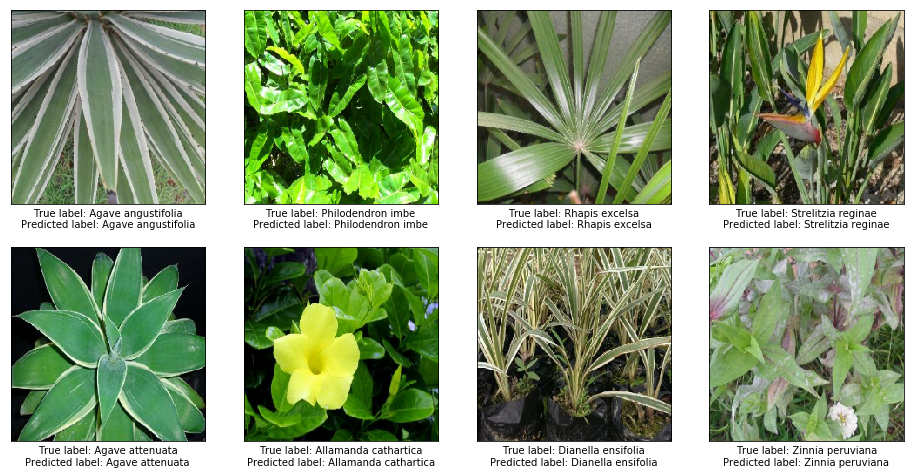

In [18]:
# Put images in [0,1] range for plotting
images = (images + 1.) / 2.
images = np.clip(images, 0., 1.)

plt.figure(figsize=(16,8))
for n, image, label, pred in zip(range(len(labels)), images, labels, preds):
    plt.subplot(2, 4, n + 1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('True label: {}\nPredicted label: {}'.format(ids_to_labels[label],
                                                            ids_to_labels[pred]))

### Citation
If the Plantas50 database was useful in your publications, please cite:

    @inproceedings{plantas-db-2016,
    author={Dias, Ren{\'e} Octavio Queiroz and Borges, D{\'i}bio Leandro},
    booktitle={2016 IEEE International Symposium on Multimedia (ISM)},
    title={Recognizing Plant Species in the Wild: Deep Learning Results and a New Database},
    year={2016},
    pages={197-202},
    doi={10.1109/ISM.2016.0047},
    isbn={978-1-5090-4571-6/16},
    url={https://doi.org/10.1109/ISM.2016.0047},
    month={Dec},}

### Legal
- Plantas50Basic and Plantas50Extra by René Octavio Queiroz Dias are licensed under a Creative Commons Attribution 4.0 International License.

- Some images of Plantas50Internet subset may have copyright. Training and using recognition model for research or non-commercial use may constitute fair use of data.

- All code is under MIT license, unless stated otherwise in the header of the code.